In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aisynphys.database import SynphysDatabase, default_db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs

pd.options.display.max_columns=200
pd.options.display.max_rows=300
# fix slow autocomplete
%config Completer.use_jedi = False
plt.rcParams["font.sans-serif"] = "Arial"
sns.set(style='ticks', context='notebook')

In [3]:
db = default_db
session = db.session()

In [4]:
cell_info = (session.query(db.Cell)
                .outerjoin(db.Morphology)
                .outerjoin(db.CorticalCellLocation)
                .outerjoin(db.Intrinsic)
                .add_columns(db.Morphology.cortical_layer)
                .add_entity(db.CorticalCellLocation)
                .add_entity(db.Intrinsic)
                .dataframe())
cell_info = cell_info.loc[:, lambda df: ~df.columns.duplicated()]
cell_info = cell_info.set_index('id')

In [5]:
e_class =  CellClass(cell_class_nonsynaptic='ex', name='excit')
i_class = CellClass(cell_class_nonsynaptic='in', name='inhib')
# e_23_class =  CellClass(dendrite_type='spiny', cortical_layer='2/3')


In [6]:
human_pair_query_args = {
#     'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
    'species': 'human',
    'filter_exprs': [db.Synapse.latency < 3e-3]
}
def get_pairs(pre_class, post_class, **kwargs):
    pair_query = db.pair_query(
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
            **kwargs
    ).add_entity(db.Dynamics).add_entity(db.Synapse)
    
    pairs_df = (pair_query.dataframe()
                .join(cell_info, on='pre_cell_id', rsuffix='_r')
                .join(cell_info, on='post_cell_id', rsuffix='_post')
               )
    print(f"{len(pairs_df)} pairs, {pairs_df.fractional_layer_depth.notna().sum()} with depth info")
    return pairs_df

# STP-depth analysis

In [30]:
e_23_class =  CellClass(cell_class='ex', cortical_layer='2/3')
mouse_pairs_df = get_pairs(e_23_class, None, species='mouse')

143 pairs, 134 with depth info


In [77]:
e_23_class =  CellClass(cell_class='ex', cortical_layer=('2','3'))
# human_pairs_df = get_pairs(e_23_class, e_23_class, **human_pair_query_args)
human_pairs_df = get_pairs(e_23_class, None, **human_pair_query_args)

181 pairs, 172 with depth info


In [104]:
# avg layer thicknesses
l2 = 407.2001623338 - 247.2137476577
l3 = 1363.9197375716 - 407.2001623338

df = human_pairs_df
df.loc[df.cortical_layer=='2', 'l23_depth'] = l2/(l2+l3)*df.loc[df.cortical_layer=='2', 'fractional_layer_depth']
df.loc[df.cortical_layer=='3', 'l23_depth'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[df.cortical_layer=='3', 'fractional_layer_depth']
df.loc[df.cortical_layer_post=='2', 'l23_depth_post'] = l2/(l2+l3)*df.loc[
    df.cortical_layer_post=='2', 'fractional_layer_depth_post']
df.loc[df.cortical_layer_post=='3', 'l23_depth_post'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[
    df.cortical_layer_post=='3', 'fractional_layer_depth_post']

mouse_pairs_df['l23_depth'] = mouse_pairs_df['fractional_layer_depth']

In [82]:
import statsmodels.formula.api as smf
def fit_conf_int(data, x, y):
    cov_type = "HC3"
    res = smf.ols(formula=f"{y}~{x}", data=data).fit(cov_type=cov_type)
    coeff = res.params[x]
#     err = res.bse[x]
    conf_int = res.conf_int().loc[x]
    return {'coeff':coeff,
            'coeff_min':conf_int[0],
            'coeff_max':conf_int[1],
            'prop':y}

Text(0.5, 0, '$\\Delta$ STP by depth (L2/3)')

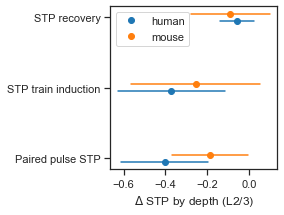

In [157]:

prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
    "stp_recovery_250ms": 'STP recovery',
}
props = prop_names.keys()
x = 'l23_depth'
human_res = pd.DataFrame.from_records( [fit_conf_int(human_pairs_df, x, y) for y in props])
mouse_res = pd.DataFrame.from_records( [fit_conf_int(mouse_pairs_df, x, y) for y in props])

dx = 0.05
x = np.arange(len(props))
colors = {'human':'tab:blue',
         'mouse':'tab:orange'}

plt.figure(figsize=(3,3))
species='human'
plt.plot(human_res.coeff, x-dx, 'o', label=species, c=colors[species])
for i in x:
    plt.plot(human_res.loc[i, ['coeff_min','coeff_max']], 2*[i-dx], c=colors[species])
species='mouse'
plt.plot(mouse_res.coeff, x+dx, 'o', label=species, c=colors[species])
for i in x:
    plt.plot(mouse_res.loc[i, ['coeff_min','coeff_max']], 2*[i+dx], c=colors[species])

plt.legend()
plt.yticks(ticks=x, labels=[prop_names[p] for p in props])
plt.xlabel('$\Delta$ STP by depth (L2/3)')

In [118]:
human_pairs_df = human_pairs_df.loc[:, lambda df: ~df.columns.duplicated()]
mouse_pairs_df = mouse_pairs_df.loc[:, lambda df: ~df.columns.duplicated()]
data = pd.concat([human_pairs_df.assign(species='human'), mouse_pairs_df.assign(species='mouse')], sort=True)

(-1, 1)

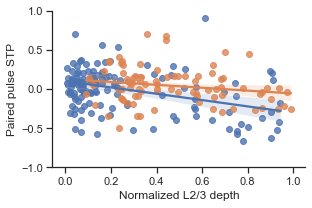

In [135]:
x = 'l23_depth'
y = 'stp_initial_50hz'
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('Normalized L2/3 depth')
plt.ylabel(prop_names[y])
plt.ylim(-1,1)

(-1, 1)

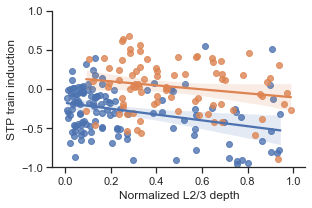

In [136]:
x = 'l23_depth'
y = 'stp_induction_50hz'
# fig, ax = plt.subplots(figsize=(3,4))
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('Normalized L2/3 depth')
plt.ylabel(prop_names[y])
plt.ylim(-1,1)

### Depth-ephys

Text(18.210000000000008, 0.5, 'AP upstroke/downstroke ratio')

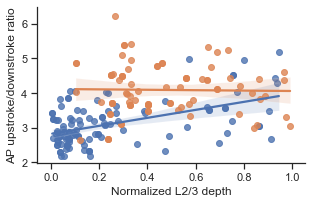

In [150]:
x = 'l23_depth'
y = 'upstroke_downstroke_ratio'
# fig, ax = plt.subplots(figsize=(3,4))
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('Normalized L2/3 depth')
plt.ylabel('AP upstroke/downstroke ratio')

Text(0.5, 8.959999999999994, 'Normalized L2/3 depth')

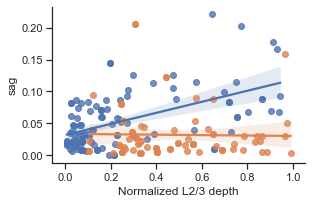

In [149]:
x = 'l23_depth'
y = 'sag'
# fig, ax = plt.subplots(figsize=(3,4))
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('Normalized L2/3 depth')

### Ephys-STP

(-1, 1)

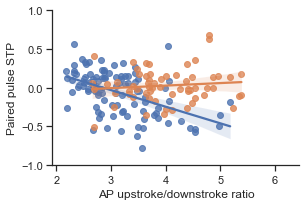

In [137]:
x = 'upstroke_downstroke_ratio'
y = 'stp_initial_50hz'
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('AP upstroke/downstroke ratio')
plt.ylabel(prop_names[y])
plt.ylim(-1,1)

(-1, 1)

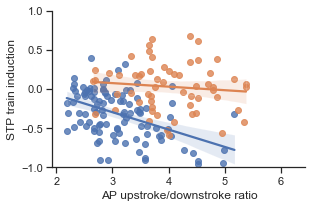

In [138]:
x = 'upstroke_downstroke_ratio'
y = 'stp_induction_50hz'
sns.lmplot(data=data, x=x, y=y, hue='species', height=3, aspect=1.5, legend=False)
plt.xlabel('AP upstroke/downstroke ratio')
plt.ylabel(prop_names[y])
plt.ylim(-1,1)

### Split by postsynaptic class

In [2]:
import sys
sys.path.append('/home/tom.chartrand/work/ateam-tools/ateam/analysis/')
import hivscc_analysis as tools

from importlib import reload
reload(tools)

<module 'hivscc_analysis' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/hivscc_analysis.py'>

(-1, 1)

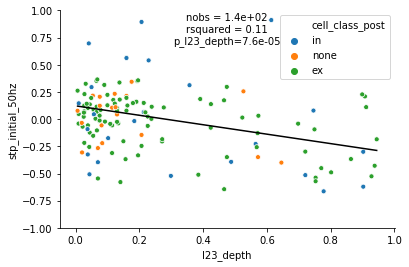

In [168]:
y = 'stp_initial_50hz'
x = 'l23_depth'
hue = 'cell_class_post'
tools.plot_fit(human_pairs_df, y, x, cluster=hue, print_attr=['nobs', 'rsquared'], legend='full')
plt.ylim(-1,1)

(-1, 1)

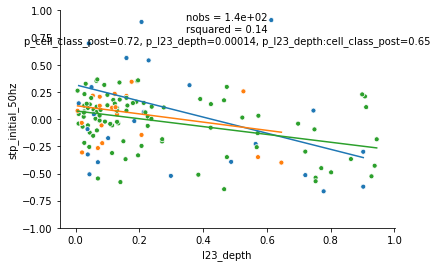

In [169]:
y = 'stp_initial_50hz'
x = 'l23_depth*cell_class_post'
hue = 'cell_class_post'
tools.plot_fit(human_pairs_df, y, x, cluster=hue, print_attr=['nobs', 'rsquared'])
plt.ylim(-1,1)

(-1, 1)

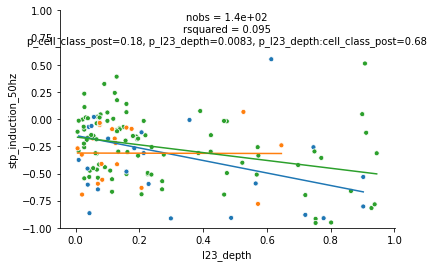

In [170]:
y = 'stp_induction_50hz'
x = 'l23_depth*cell_class_post'
hue = 'cell_class_post'
tools.plot_fit(human_pairs_df, y, x, cluster=hue, print_attr=['nobs', 'rsquared'])
plt.ylim(-1,1)

### Human recurrent only

In [105]:
pairs_df = human_pairs_df[human_pairs_df.cell_class_post=='ex']

(-1, 1)

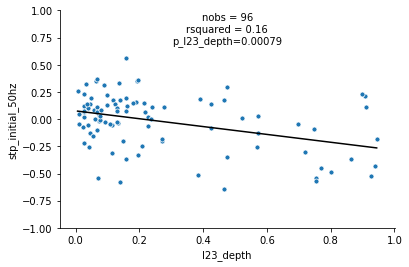

In [209]:
y = 'stp_initial_50hz'
x = 'l23_depth'
tools.plot_fit(pairs_df, y, x, cluster=None, print_attr=['nobs', 'rsquared'])
plt.ylim(-1,1)

In [7]:
plot_props = [
#     synapse
    'latency',
    'psp_amplitude',
    'psp_rise_time',
    'psp_decay_tau',
    'psc_amplitude',
    'psc_rise_time',
    'psc_decay_tau',
#     dynamics
#     'paired_pulse_ratio_50hz',
    'stp_initial_50hz',
    'stp_induction_50hz',
    'stp_recovery_250ms',
#     'stp_recovery_single_250ms',
    'pulse_amp_90th_percentile',
    'variability_resting_state',
    'variability_second_pulse_50hz',
    'paired_event_correlation_1_2_r',
    'paired_event_correlation_2_4_r',
]

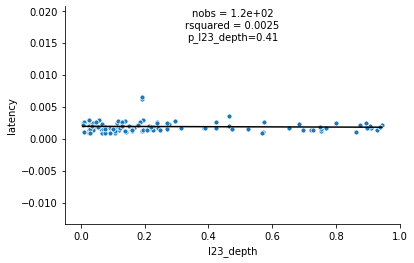

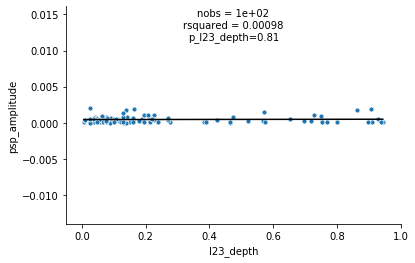

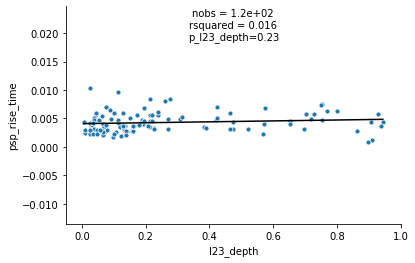

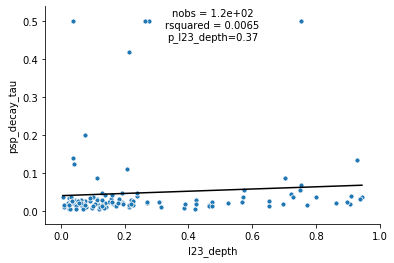

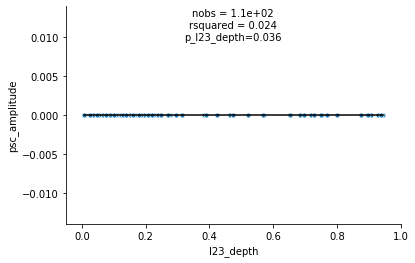

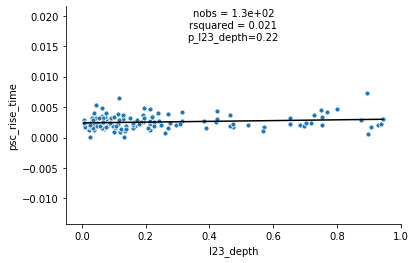

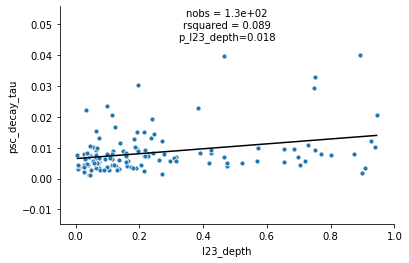

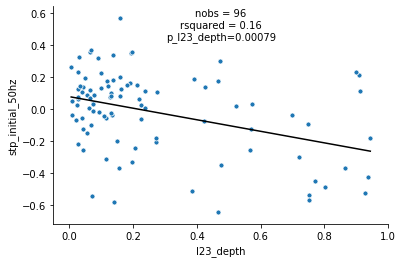

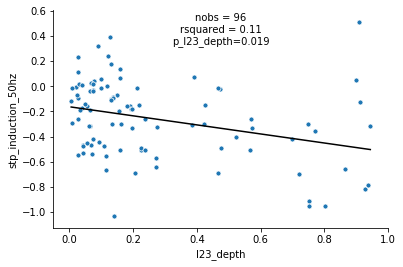

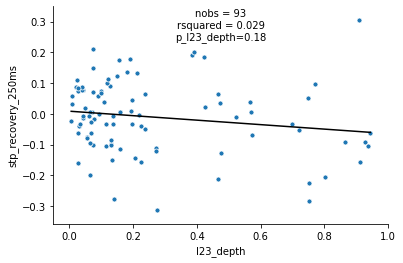

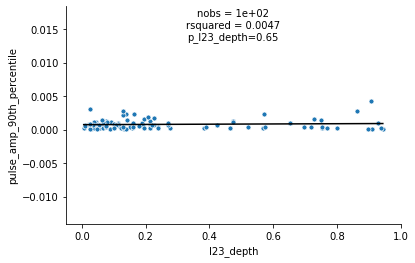

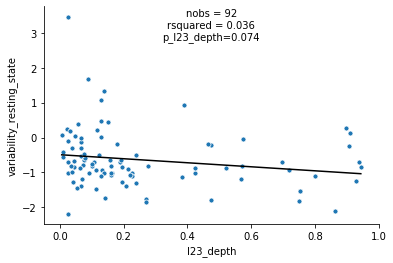

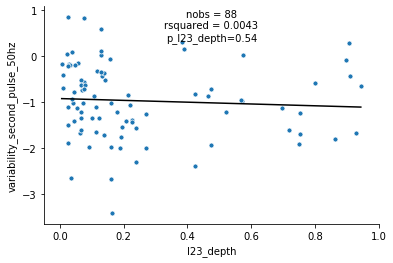

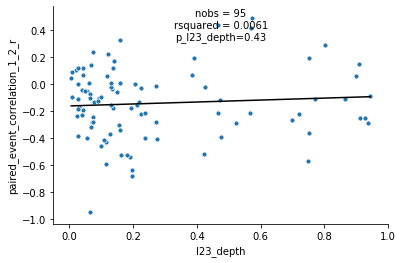

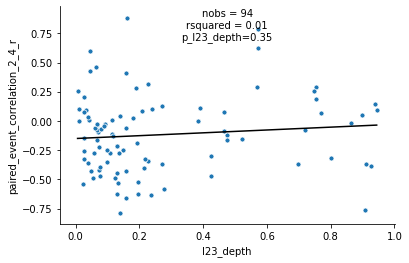

In [87]:
x = 'l23_depth'
for y in plot_props:
    tools.plot_fit(pairs_df, y, x, cluster=None, print_attr=['nobs', 'rsquared'])

### Mouse details

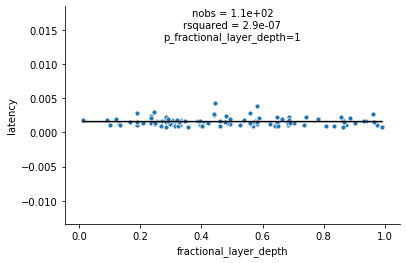

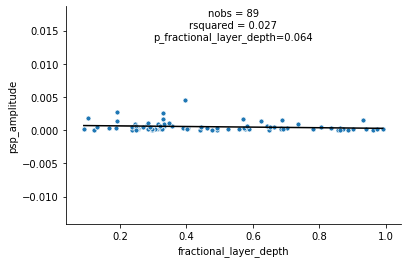

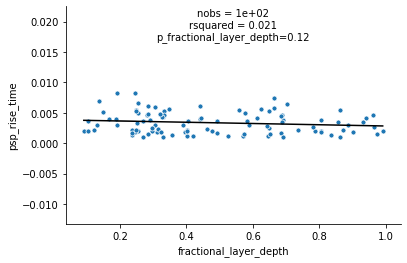

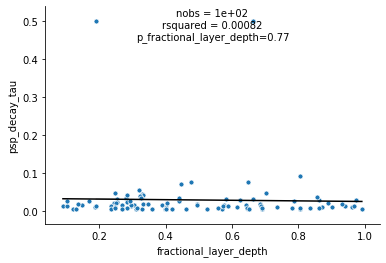

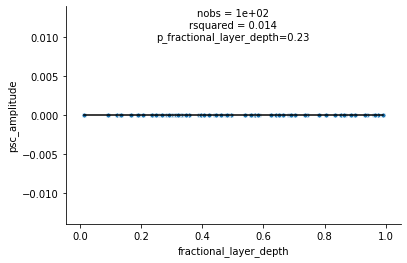

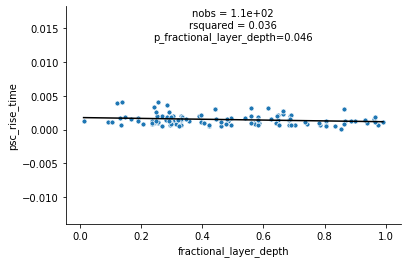

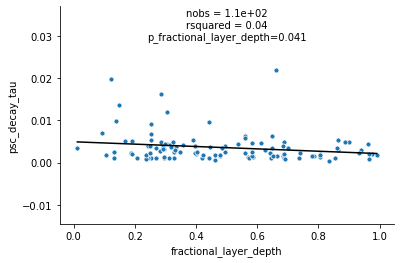

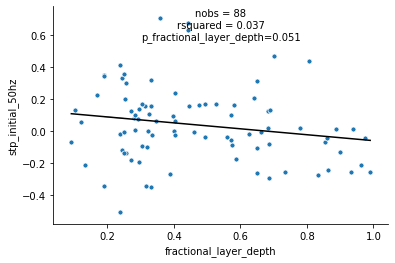

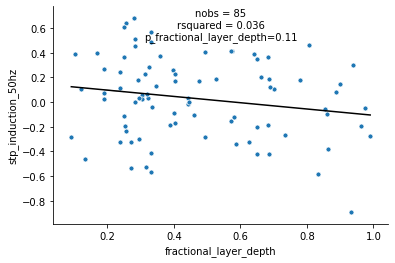

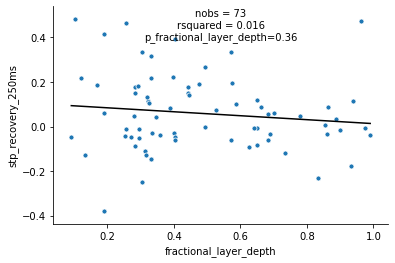

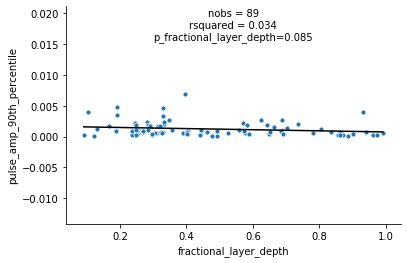

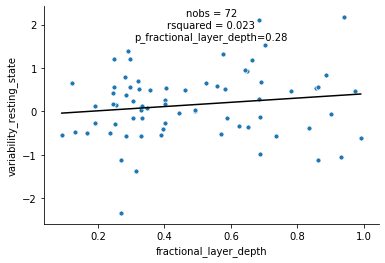

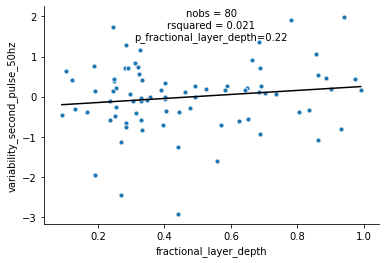

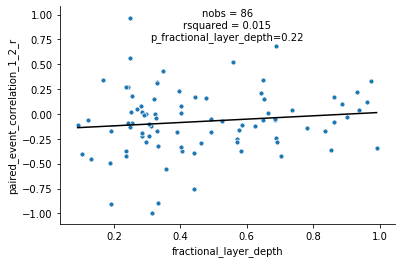

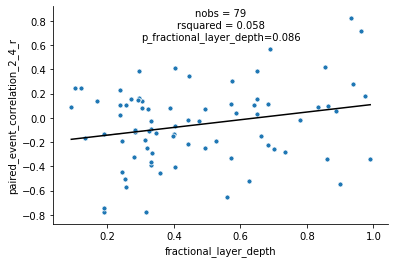

In [162]:
x = 'fractional_layer_depth'
for y in plot_props:
    tools.plot_fit(mouse_pairs_df, y, x, cluster=None, print_attr=['nobs', 'rsquared'])

(-1, 1)

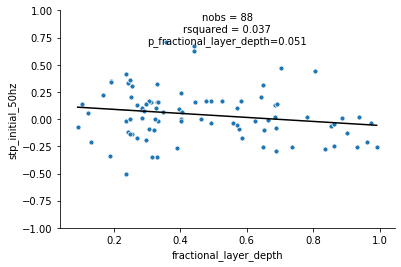

In [163]:
y = 'stp_initial_50hz'
x = 'fractional_layer_depth'
tools.plot_fit(mouse_pairs_df, y, x, cluster=None, print_attr=['nobs', 'rsquared'])
plt.ylim(-1,1)

### All layers STP-depth

In [138]:
exc_class =  CellClass(cell_class='ex')
pairs_df = get_pairs(exc_class, exc_class, species='human')

211 pairs, 177 with depth info


In [139]:
pairs_df.cortical_layer += '_'

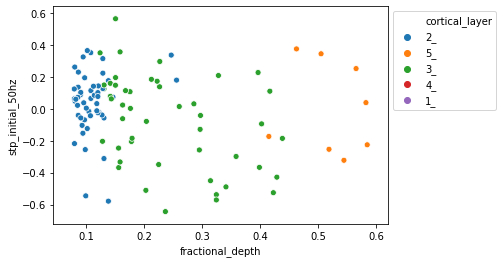

In [119]:
y = 'stp_initial_50hz'
x = 'fractional_depth'
sns.scatterplot(data=pairs_df, x=x, y=y, hue='cortical_layer')
plt.legend(bbox_to_anchor=(1,1))

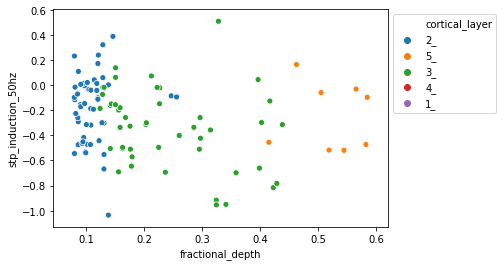

In [120]:
y = 'stp_induction_50hz'
x = 'fractional_depth'
sns.scatterplot(data=pairs_df, x=x, y=y, hue='cortical_layer')
plt.legend(bbox_to_anchor=(1,1))

In [97]:
exc_class =  CellClass(cell_class='ex')
pairs_df = get_pairs(exc_class, exc_class, species='mouse')

270 pairs, 228 with depth info


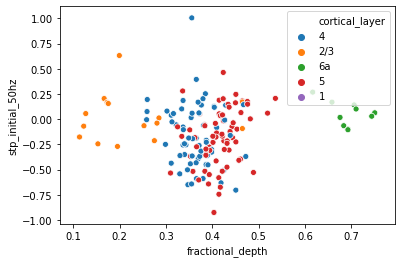

In [100]:
y = 'stp_initial_50hz'
x = 'fractional_depth'
sns.scatterplot(data=pairs_df, x=x, y=y, hue='cortical_layer')

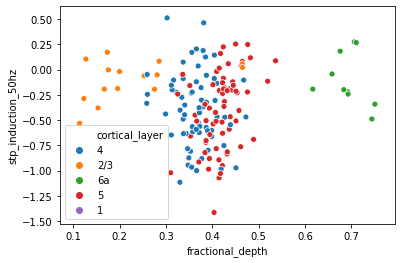

In [102]:
y = 'stp_induction_50hz'
x = 'fractional_depth'
sns.scatterplot(data=pairs_df, x=x, y=y, hue='cortical_layer')

# Polysynaptic connection depths

In [106]:
exc =  CellClass(cell_class='ex')
pair_query = db.pair_query(
            pre_class=exc,
            post_class=exc,
            synapse=False,
).filter(db.Pair.has_polysynapse==True).add_entity(db.Dynamics).add_entity(db.PolySynapse)

pairs_df = (pair_query.dataframe()
            .join(cell_info, on='pre_cell_id', rsuffix='_r')
            .join(cell_info, on='post_cell_id', rsuffix='_post')
           )
print(f"{len(pairs_df)} pairs, {pairs_df.fractional_layer_depth.notna().sum()} with depth info")

39 pairs, 37 with depth info


In [107]:
df = pairs_df
df.loc[df.cortical_layer=='2', 'l23_depth'] = l2/(l2+l3)*df.loc[df.cortical_layer=='2', 'fractional_layer_depth']
df.loc[df.cortical_layer=='3', 'l23_depth'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[df.cortical_layer=='3', 'fractional_layer_depth']

df.loc[df.cortical_layer_post=='2', 'l23_depth_post'] = l2/(l2+l3)*df.loc[
    df.cortical_layer_post=='2', 'fractional_layer_depth_post']
df.loc[df.cortical_layer_post=='3', 'l23_depth_post'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[
    df.cortical_layer_post=='3', 'fractional_layer_depth_post']


In [108]:
pairs_df.cortical_layer_post.value_counts()

2    19
3    15
4     3
6     2
Name: cortical_layer_post, dtype: int64

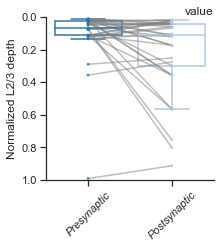

In [160]:
data = pairs_df[["l23_depth", "l23_depth_post"]].melt()
# sns.boxplot(data=data, x='variable', y='value', )
# sns.stripplot(data=data, x='variable', y='value', )
fig, ax = plt.subplots(figsize=(3,3))
tools.plot_box_cluster_feature(data=data, y='value', x='variable', strip_width=0, pairs_sets=['all'], ax=ax, palette='tab20')

data = pairs_df[["l23_depth", "l23_depth_post"]].values
for y in data:
    plt.plot(y,'grey', alpha=0.5)
plt.ylim(1,0)
plt.ylabel('Normalized L2/3 depth')
plt.xticks(ticks=[0,1], labels=['Presynaptic','Postsynaptic'])
plt.show()

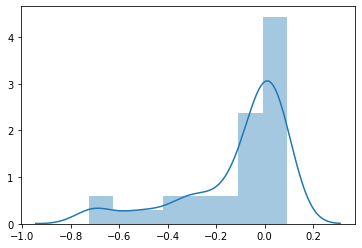

In [205]:
sns.distplot(pairs_df.l23_depth - pairs_df.l23_depth_post)

In [204]:
data = pairs_df[["l23_depth", "l23_depth_post"]].melt()
tools.pairwise_mw(data, 'value', 'variable')

([('l23_depth', 'l23_depth_post')], [[0, 1]], [0.01839718944476733])